# FPDP implementation

WE WILL USE STATISTICAL PARITY TO USE AS STATISTIC TO ASSESS FOR THE FAIRNESS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Replace 'your_file.csv' with the name of your CSV file
df = pd.read_csv('C:\\Users\\yacco\\afi_project_1\\afi_final_project\\predictions_output_gradient_boosting.csv')

# Display the first few rows of the data
df.head()

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Group,Predicted_PD,True_Label
0,2,22,8900,8900,0,60,0.084828,0,0,0,0,0.268061,1
1,0,55,10400,9400,0,72,0.083889,0,0,0,0,0.350588,0
2,1,40,15990,14990,0,60,0.127142,0,1,0,0,0.204690,1
3,5,43,19999,23233,0,72,0.153289,0,0,0,0,0.391570,0
4,1,26,11800,4298,1,24,0.115528,0,0,0,0,0.109665,0


In [2]:
df_true = df.drop(columns=['Predicted_PD', 'Group'])

In [3]:
df_true['Age_Group'] = pd.cut(df_true['Age'], bins=[0, 45, 100], labels=['Age < 45', 'Age ≥ 45'])

df_true = df_true.drop('Age', axis=1)

# Display the updated dataframe
df_true

,Job tenure,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,True_Label,Age_Group
0,2,8900,8900,0,60,0.084828,0,0,0,1,Age < 45
1,0,10400,9400,0,72,0.083889,0,0,0,0,Age ≥ 45
2,1,15990,14990,0,60,0.127142,0,1,0,1,Age < 45
3,5,19999,23233,0,72,0.153289,0,0,0,0,Age < 45
4,1,11800,4298,1,24,0.115528,0,0,0,0,Age < 45
...,...,...,...,...,...,...,...,...,...,...,...
2224,13,13170,7170,0,48,0.045833,0,1,1,0,Age ≥ 45
2225,12,2900,3135,0,36,0.065714,0,0,0,0,Age ≥ 45
2226,0,14900,10900,0,48,0.164167,0,0,0,0,Age < 45
2227,0,14990,13990,0,84,0.062667,0,1,1,0,Age ≥ 45


In [4]:
# Group by Age_Category and count the number of positive (1) and negative (0) predictions
contingency_table = pd.crosstab(df_true['Age_Group'], df_true['True_Label'])

contingency_table

True_Label,0,1
Age_Group,,
Age < 45,792,291
Age ≥ 45,996,150


In [5]:
# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("Contingency Table:\n", contingency_table)
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

Contingency Table:
 True_Label    0    1
Age_Group           
Age < 45    792  291
Age ≥ 45    996  150
Chi-Square Statistic: 65.76389945625829
P-Value: 5.083082193293602e-16


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Recreate the best Gradient Boosting model
best_gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=2,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

X = df_true.drop('True_Label', axis=1)
y = df_true['True_Label']

X['Age_Group'] = le.fit_transform(X['Age_Group'])

best_gb_model.fit(X, y)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42, subsample=0.8)

In [7]:
X

,Job tenure,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Age_Group
0,2,8900,8900,0,60,0.084828,0,0,0,0
1,0,10400,9400,0,72,0.083889,0,0,0,1
2,1,15990,14990,0,60,0.127142,0,1,0,0
3,5,19999,23233,0,72,0.153289,0,0,0,0
4,1,11800,4298,1,24,0.115528,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2224,13,13170,7170,0,48,0.045833,0,1,1,1
2225,12,2900,3135,0,36,0.065714,0,0,0,1
2226,0,14900,10900,0,48,0.164167,0,0,0,0
2227,0,14990,13990,0,84,0.062667,0,1,1,1


In [15]:
# This statistical parity formula determines the predicted default rate for both Group 0 and Group 1,
# and the difference between the predicted PD's would then be determined if statistically significant
# through a Chi Square test.

# We divide our feature set into continous/discrete. The reason is that for continuous features we will divide the data into
# bins while for discrete features we will take all values

continuous_features = ['Car price', 'Funding amount', 'Monthly payment']
discrete_features = ['Job tenure', 'Loan duration', 'Married', 'Homeowner']

# Function to perform Chi-Square test for fairness
# Age group (< or > 45) is used as a discriminant. What this function does is that, for each iteration of the estimator, 
# it computes the predictions, then builds a contingency table based on Age group and the predictions results for 
# each age group. Then we compute the p-val from the chi2 test to estimate fairness.

def chi_square_test(variable, predictions):
    contingency_table = pd.crosstab(variable, predictions, colnames=["Predictions"])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return chi2_stat, p_value, dof, expected, contingency_table

# function to compute_bins. if the feature is discrete, simply all values of the feature are returned.
def compute_bins(feature, is_continuous):
    if is_continuous:
        return pd.cut(X[feature], bins=5).unique()
    else:
        return X[feature].unique() # return all values if the feature is discrete (like marriage or homeowner)


Feature: Car price, Feature Value: 4537.8895
Contingency Table:
Predictions    0    1
Age_Group            
0            255  828
1            517  629
P-Value: 1.7135775766099203e-26


Feature: Car price, Feature Value: 12241.3
Contingency Table:
Predictions     0    1
Age_Group             
0             848  235
1            1085   61
P-Value: 9.91306109519068e-30


Feature: Car price, Feature Value: 19925.5
Contingency Table:
Predictions     0   1
Age_Group            
0            1006  77
1            1126  20
P-Value: 1.0546472301338731e-09


Feature: Car price, Feature Value: 27609.699999999997
Contingency Table:
Predictions     0   1
Age_Group            
0            1033  50
1            1127  19
P-Value: 9.273047183890153e-05


Feature: Car price, Feature Value: 35293.9
Contingency Table:
Predictions     0   1
Age_Group            
0            1066  17
1            1141   5
P-Value: 0.012735150069647962



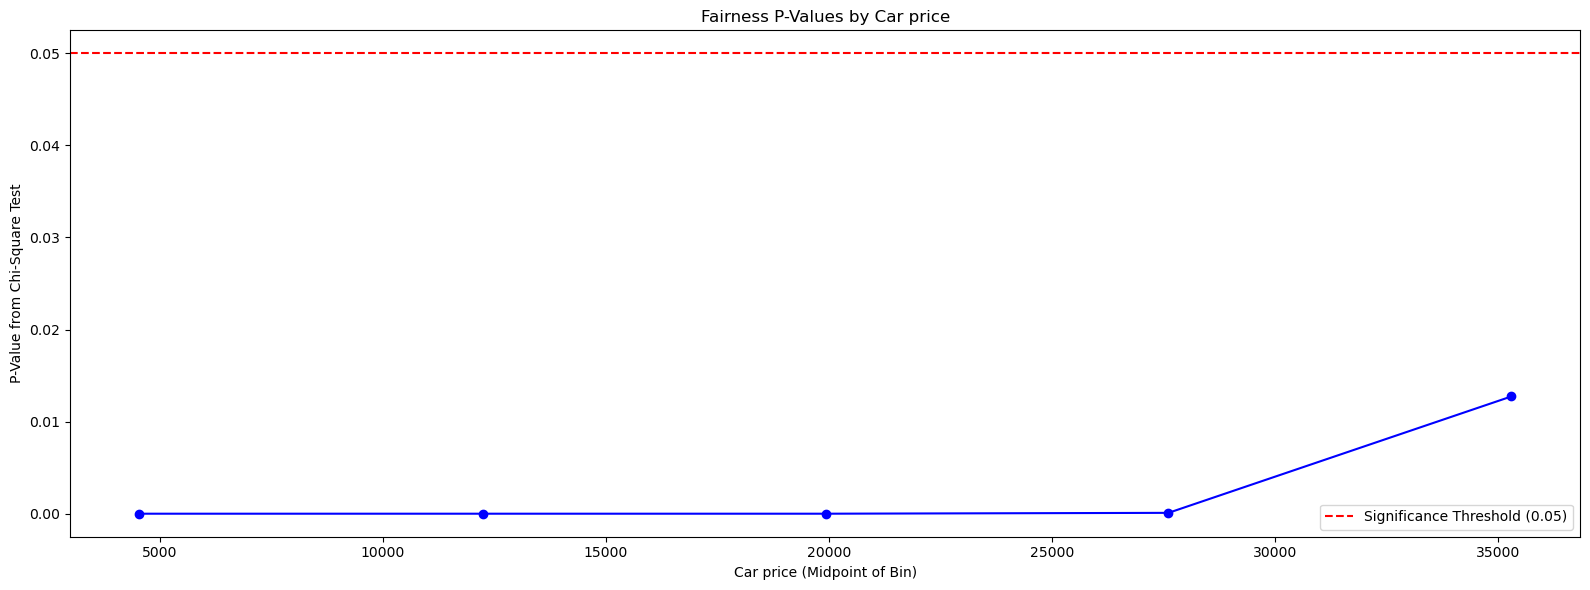


Feature: Funding amount, Feature Value: 3627.8625
Contingency Table:
Predictions     0   1
Age_Group            
0            1059  24
1            1131  15
P-Value: 0.1412800243330637


Feature: Funding amount, Feature Value: 9497.5
Contingency Table:
Predictions     0    1
Age_Group             
0             942  141
1            1085   61
P-Value: 4.0380953614430493e-10


Feature: Funding amount, Feature Value: 15352.5
Contingency Table:
Predictions    0    1
Age_Group            
0            585  498
1            806  340
P-Value: 2.6937152944123933e-15


Feature: Funding amount, Feature Value: 21207.5
Contingency Table:
Predictions    0    1
Age_Group            
0            406  677
1            719  427
P-Value: 1.5925393911922104e-32


Feature: Funding amount, Feature Value: 27062.5
Contingency Table:
Predictions    0    1
Age_Group            
0            210  873
1            339  807
P-Value: 3.1675731356794394e-08



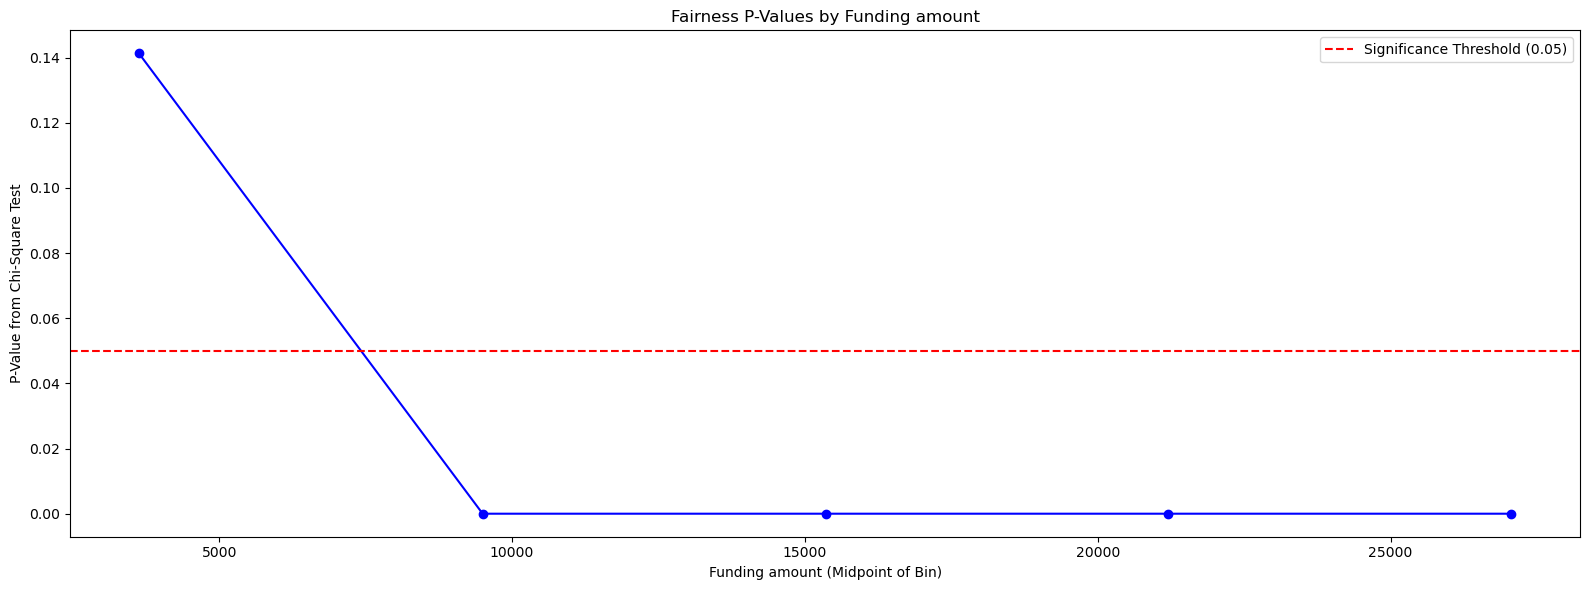


Feature: Monthly payment, Feature Value: 0.07694999999999999
Contingency Table:
Predictions     0   1
Age_Group            
0            1030  53
1            1127  19
P-Value: 2.6817172464418402e-05


Feature: Monthly payment, Feature Value: 0.20900000000000002
Contingency Table:
Predictions     0    1
Age_Group             
0             927  156
1            1117   29
P-Value: 6.819335906487557e-24


Feature: Monthly payment, Feature Value: 0.34099999999999997
Contingency Table:
Predictions    0    1
Age_Group            
0            546  537
1            683  463
P-Value: 1.601346859234992e-05


Feature: Monthly payment, Feature Value: 0.473
Contingency Table:
Predictions    0    1
Age_Group            
0            678  405
1            802  344
P-Value: 0.0002713208748323533


Feature: Monthly payment, Feature Value: 0.6045
Contingency Table:
Predictions    0    1
Age_Group            
0            678  405
1            802  344
P-Value: 0.0002713208748323533



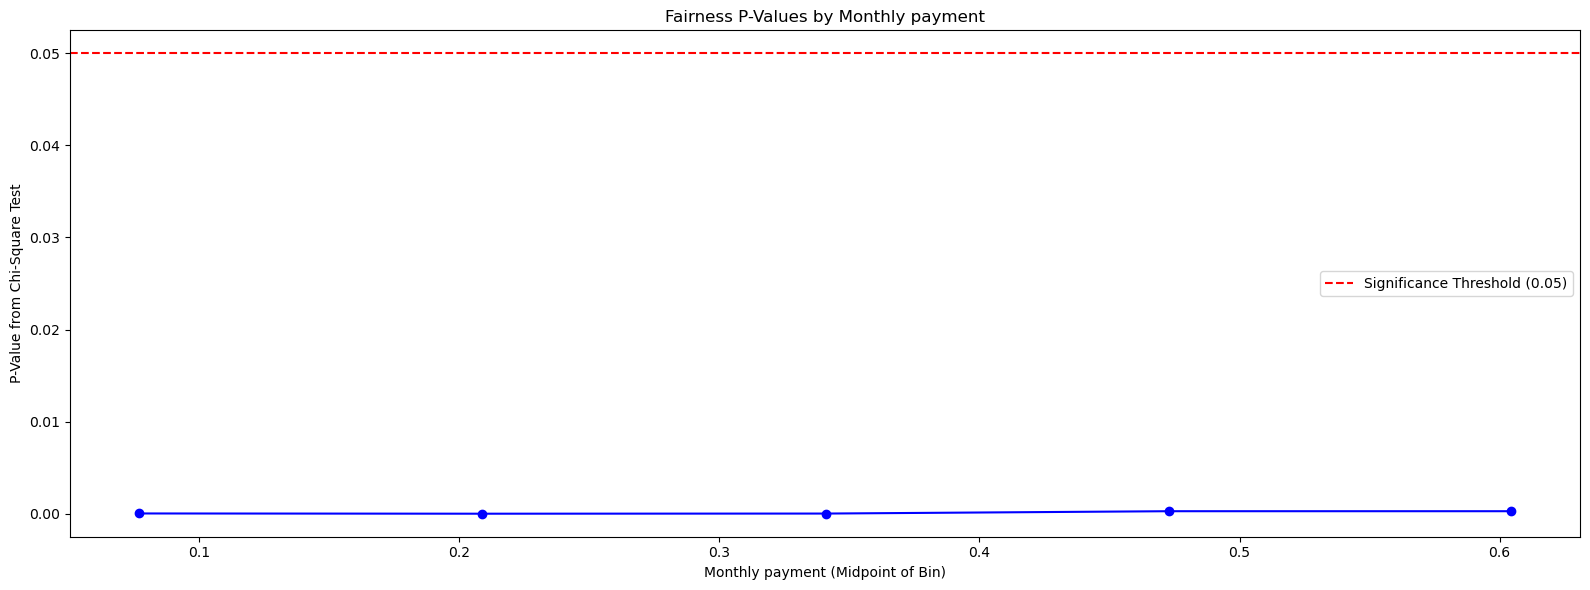


Feature: Job tenure, Feature Value: 0
Contingency Table:
Predictions     0    1
Age_Group             
0             863  220
1            1088   58
P-Value: 2.502582475009176e-27


Feature: Job tenure, Feature Value: 1
Contingency Table:
Predictions     0    1
Age_Group             
0             863  220
1            1089   57
P-Value: 1.0509664633061282e-27


Feature: Job tenure, Feature Value: 2
Contingency Table:
Predictions     0    1
Age_Group             
0             881  202
1            1094   52
P-Value: 2.122498407249876e-25


Feature: Job tenure, Feature Value: 3
Contingency Table:
Predictions     0    1
Age_Group             
0             928  155
1            1095   51
P-Value: 1.6945837073912643e-15


Feature: Job tenure, Feature Value: 4
Contingency Table:
Predictions     0    1
Age_Group             
0             982  101
1            1105   41
P-Value: 4.57475048369337e-08


Feature: Job tenure, Feature Value: 5
Contingency Table:
Predictions     0   1
Age_Group

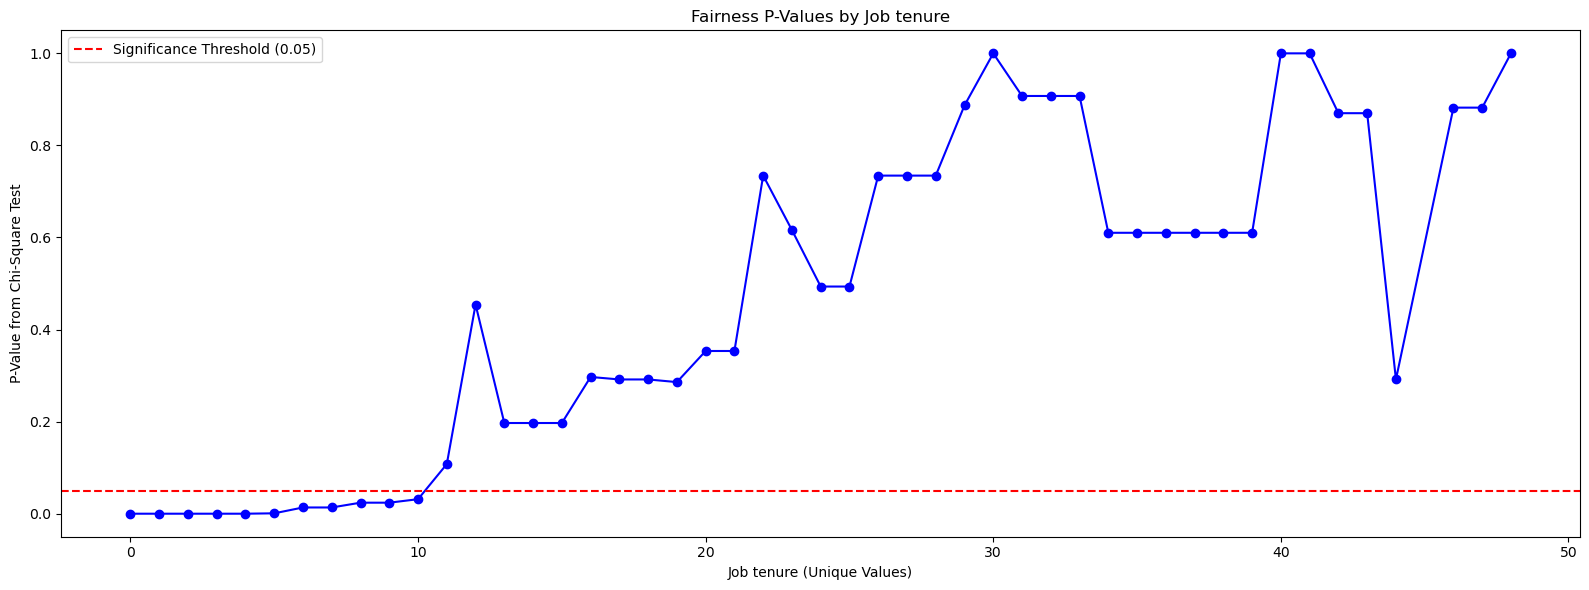


Feature: Loan duration, Feature Value: 8
Contingency Table:
Predictions     0    1
Age_Group             
0             800  283
1            1075   71
P-Value: 1.3981528743410898e-37


Feature: Loan duration, Feature Value: 12
Contingency Table:
Predictions     0   1
Age_Group            
0            1032  51
1            1124  22
P-Value: 0.00034472561902657765


Feature: Loan duration, Feature Value: 15
Contingency Table:
Predictions     0   1
Age_Group            
0            1032  51
1            1124  22
P-Value: 0.00034472561902657765


Feature: Loan duration, Feature Value: 17
Contingency Table:
Predictions     0   1
Age_Group            
0            1032  51
1            1124  22
P-Value: 0.00034472561902657765


Feature: Loan duration, Feature Value: 18
Contingency Table:
Predictions     0   1
Age_Group            
0            1032  51
1            1124  22
P-Value: 0.00034472561902657765


Feature: Loan duration, Feature Value: 24
Contingency Table:
Predictions     0   

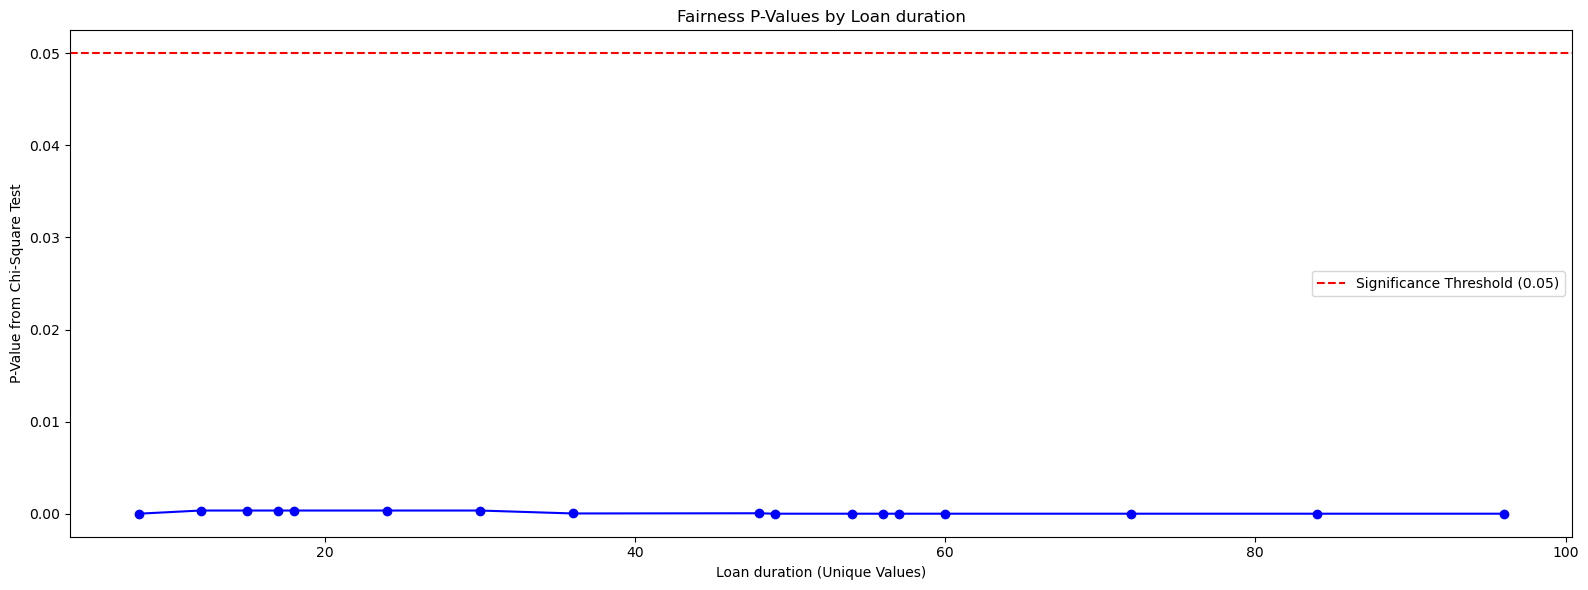


Feature: Married, Feature Value: 0
Contingency Table:
Predictions     0    1
Age_Group             
0             916  167
1            1104   42
P-Value: 3.620492330626514e-21


Feature: Married, Feature Value: 1
Contingency Table:
Predictions     0    1
Age_Group             
0             982  101
1            1112   34
P-Value: 5.577975363959594e-10



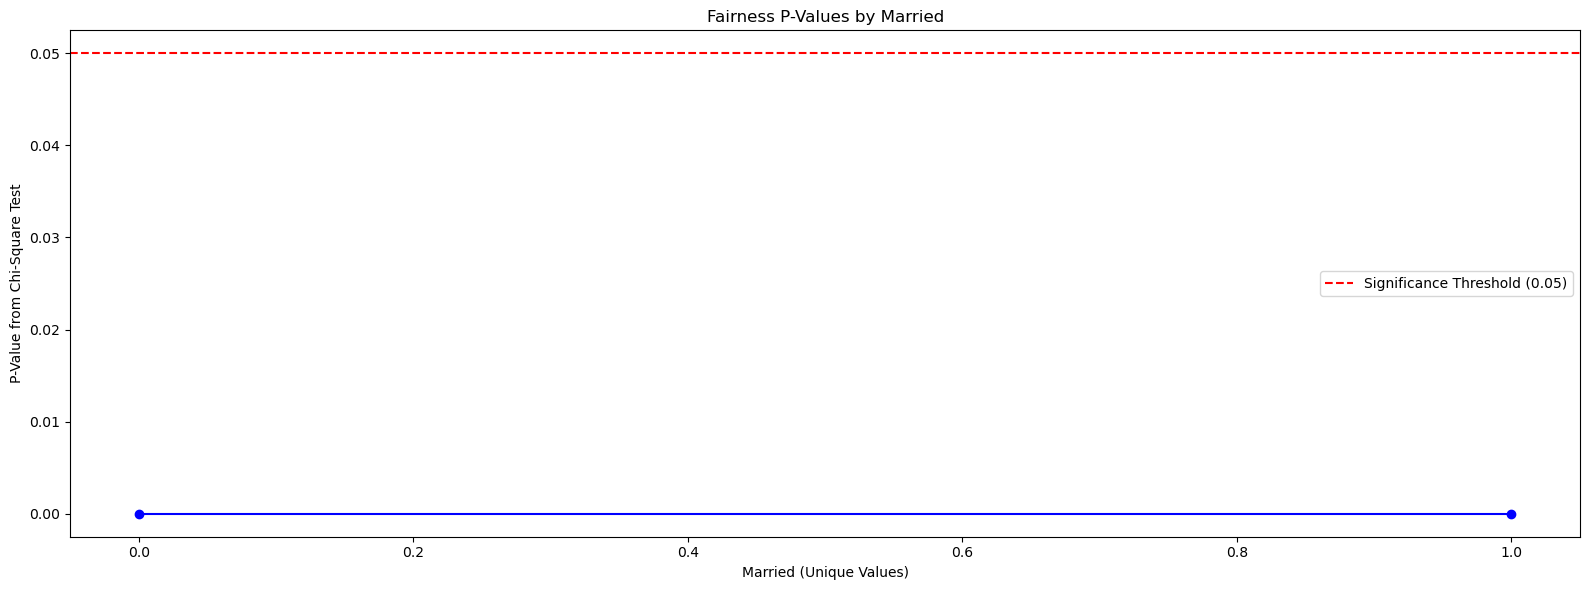


Feature: Homeowner, Feature Value: 0
Contingency Table:
Predictions     0    1
Age_Group             
0             917  166
1            1109   37
P-Value: 6.888564622787207e-23


Feature: Homeowner, Feature Value: 1
Contingency Table:
Predictions     0   1
Age_Group            
0            1013  70
1            1116  30
P-Value: 1.856783223783077e-05



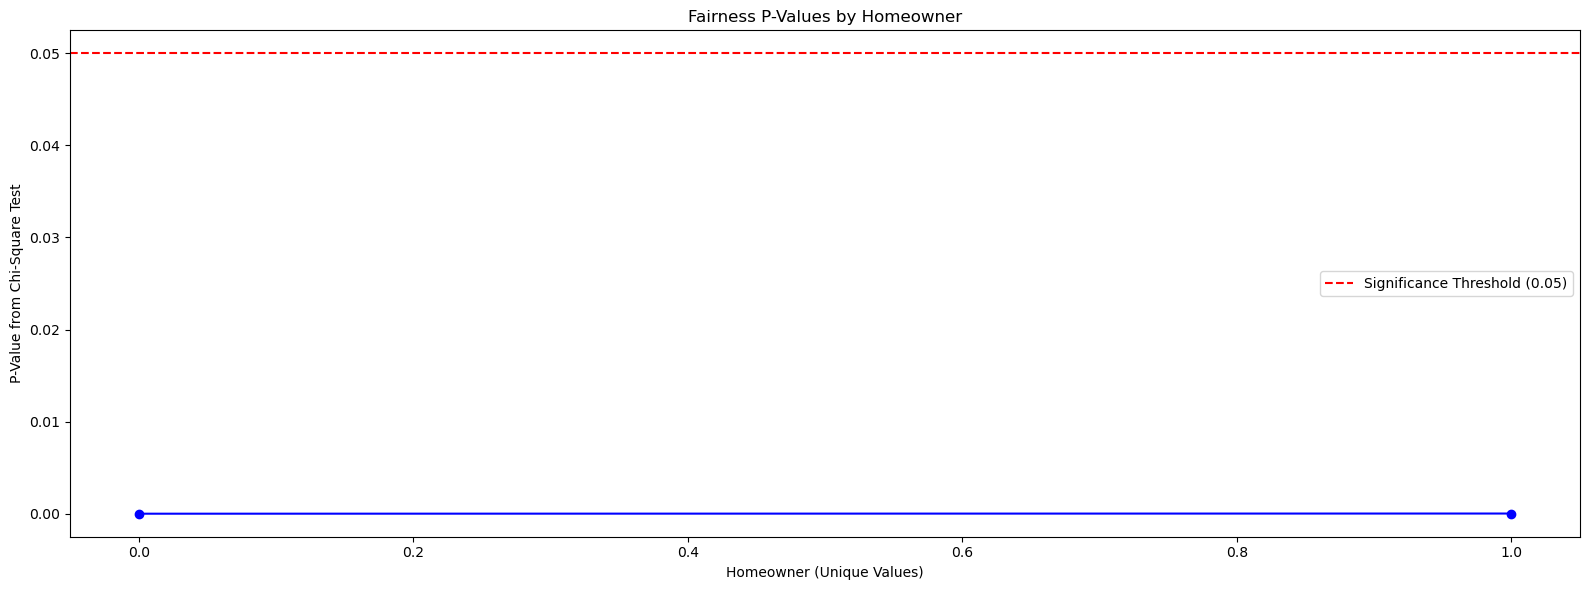

In [20]:
# Combine the continuous and discrete feature lists into one loop
features = continuous_features + discrete_features

# Iterate over each feature to compute p-values and plot
for feature in features:
    bin_midpoints_pvalues = []
    
    # Check if the feature is continuous
    is_continuous = feature in continuous_features
    
    # Compute bins (for continuous features) or take all unique values (for discrete features)
    bin_vals = compute_bins(feature, is_continuous)
    
    # Iterate over each bin or unique value and fix the feature to that value
    for bin_val in bin_vals:
        if is_continuous:
            # For continuous features, calculate the midpoint of the bin
            midpoint = (bin_val.left + bin_val.right) / 2
            feature_value = midpoint
        else:
            # For discrete features, use the unique value directly
            feature_value = bin_val
        
        # fix the feature's value
        X_temp = X.copy()
        X_temp[feature] = feature_value
        
        # Predict binary outcomes using the OPTIMAL black box model
        predictions = best_gb_model.predict(X_temp)
        
        # Perform Chi-Square test for fairness
        chi2_stat, p_value, dof, expected, contingency_table = chi_square_test(X_temp['Age_Group'], predictions)
        
        # Store the (feature value, p-value, contingency table) pair
        bin_midpoints_pvalues.append((feature_value, p_value, contingency_table))
    
    # Sort the list based on the feature values 
    bin_midpoints_pvalues.sort(key=lambda x: x[0])  # Sort by the first element (feature value)
    
    # Print the contingency table and p-value in the correct sorted order
    for feature_value, p_value, contingency_table in bin_midpoints_pvalues:
        print(f"\nFeature: {feature}, Feature Value: {feature_value}")
        print("Contingency Table:")
        print(contingency_table)
        print(f"P-Value: {p_value}\n")
    
    # Separate ONLY the bin_midpoints and p_values to plot them
    bin_midpoints, p_values = zip(*[(x[0], x[1]) for x in bin_midpoints_pvalues])
    
    # Plot the p-values for the current feature
    plt.figure(figsize=(16, 6)) 
    plt.plot(bin_midpoints, p_values, marker='o', linestyle='-', color='b')
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
    plt.xlabel(f'{feature} (Midpoint of Bin)' if is_continuous else f'{feature} (Unique Values)')
    plt.ylabel('P-Value from Chi-Square Test')
    plt.title(f'Fairness P-Values by {feature}')
    plt.legend()
    plt.tight_layout()
    plt.show()